In [1]:
import numpy as np
from scipy.stats import norm
import torch

In [2]:
# 读取二维坐标数据
kdTree = torch.load("./static/data/CIFAR10/2D_kdTree/2D_kdTree_200000.pt")
pos_data = kdTree.data

In [3]:
pos_data[:5]

array([[-23.8795429 ,  39.88835972],
       [ 28.21886537,  -6.30531846],
       [-51.10693958,   3.72316302],
       [-31.52258421, -33.80048417],
       [-34.65737393, -27.36477258]])

In [4]:
# 对数据进行归一化处理，使其均值为0，方差为1
data_norm = (pos_data - np.mean(pos_data, axis=0)) / np.std(pos_data, axis=0)

In [5]:
np.mean(pos_data, axis=0)

array([-7.13065162e-16, -8.98237040e-17])

In [6]:
data_norm[:5]

array([[-0.69741615,  1.36278325],
       [ 0.82414862, -0.2154208 ],
       [-1.49260834,  0.12720163],
       [-0.92063568, -1.15479138],
       [-1.01218907, -0.9349157 ]])

In [7]:
# 分别拟合正态分布，并得到均值和标准差：
mu_x, std_x = norm.fit(data_norm[:, 0])
mu_y, std_y = norm.fit(data_norm[:, 1])

In [8]:
# 将二维坐标映射到正态分布中
data_norm_to_normal_x = norm.cdf(data_norm[:, 0], loc=mu_x, scale=std_x)
data_norm_to_normal_y = norm.cdf(data_norm[:, 1], loc=mu_y, scale=std_y)

In [9]:
print(data_norm_to_normal_x[:3])
print(data_norm_to_normal_y[:3])

[0.2427712  0.79507244 0.06776987]
[0.91352458 0.41471963 0.55060959]


In [10]:
# 将data_norm_to_normal_x和data_norm_to_normal_y组合在一起，可以得到一个二维坐标数组
data_norm_to_normal = np.column_stack((data_norm_to_normal_x, data_norm_to_normal_y))

In [11]:
data_norm_to_normal[:3]

array([[0.2427712 , 0.91352458],
       [0.79507244, 0.41471963],
       [0.06776987, 0.55060959]])

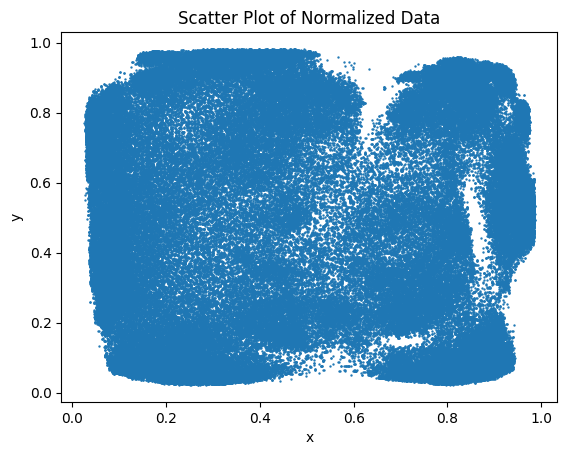

In [12]:
import matplotlib.pyplot as plt
plt.scatter(data_norm_to_normal[:, 0], data_norm_to_normal[:, 1], s=0.5)
# 添加坐标轴标签和图标题
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot of Normalized Data')
plt.show()

### 在这个符合正态二维空间中进行采样

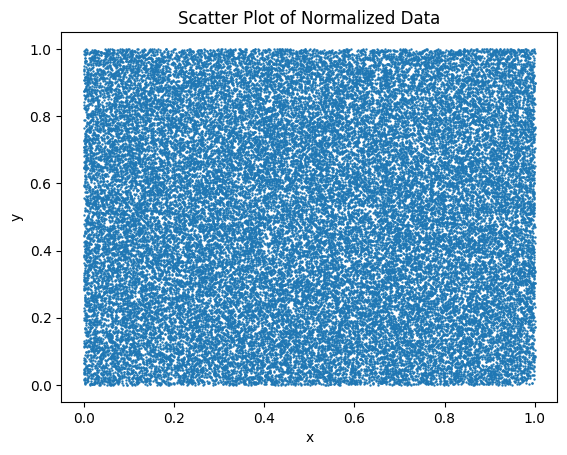

In [13]:
# 符合原始数据的分布进行采样
x = np.random.normal(mu_x, std_x, size=50000)
y = np.random.normal(mu_y, std_y, size=50000)
coords = np.column_stack((x, y))
# 将坐标点映射到正态分布中
coords_norm = norm.cdf((coords - np.mean(coords, axis=0)) / np.std(coords, axis=0), loc=0, scale=1)
plt.scatter(coords_norm[:, 0], coords_norm[:, 1], s=0.5)
# 添加坐标轴标签和图标题
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot of Normalized Data')
plt.show()

In [14]:
latent_z_path="./static/data/CIFAR10/latent_z/BigGAN_208z_200000.pt"
latent_z = torch.load(latent_z_path, map_location="cpu") #因为我之前保存数据到了GPU上，所以要回到cpu上才不会出错

In [15]:
from scipy import spatial
norm_tree =  spatial.KDTree(data=data_norm_to_normal)

In [16]:
def get_zs_prevent_stick(coordinates, kdTree_2D, latent_z, k=10):
    '''
    nearest_distance: n*k维
    nearest_index: n*k维
    dict_zs: 键是文件的id号, 值是对应的z（后面直接改成数组了，问题不大）
    '''
    print("进入了防止粘在一块~~~~~~~~~~~~~~~~~~")
    # 直接一次查询所有坐标的k个近邻
    nearest_distance, nearest_index = kdTree_2D.query(coordinates, k=k)
    origin_coordinates = kdTree_2D.data # 获取kdtree中原始的坐标
    for i, pos in enumerate(coordinates): #对每一个坐标进行插值
        # pos坐标对应的近邻下标
        pos_nearst_index = nearest_index[i] # 其中有k个index，每个index对应kdTree_2D中的一个2维坐标
        pos_nearst_distance = nearest_distance[i]

        # 最近邻的坐标点，以及最近的距离
        most_nearst_pos = origin_coordinates[pos_nearst_index[0]]
        most_nearst_dis = pos_nearst_distance[0]

        # 利用三角形,找到第二个插值基点，让两边之和越接近第三边，就越是钝角，就越合理
        s1 = most_nearst_dis
        best_index = 1 # 默认第二个最近邻最好
        min_dif = 100
        for j in range(1, k):
            cur_pos = origin_coordinates[pos_nearst_index[j]]
            s2 = pos_nearst_distance[j]
            s3 = np.linalg.norm(most_nearst_pos-cur_pos)
            if (s1 + s2) - s3 < min_dif: # 两边之和大于等于第三边，所以不用绝对值
                min_dif = (s1 + s2) - s3
                best_index = j
        
        temp_z_0 = latent_z[pos_nearst_index[0]].clone().detach()
        temp_z_1 = latent_z[pos_nearst_index[best_index]].clone().detach()
        sum_distance = most_nearst_dis + pos_nearst_distance[best_index]
        z_new = (sum_distance-most_nearst_dis)/(sum_distance) * temp_z_0 + (sum_distance-pos_nearst_distance[best_index])/(sum_distance) * temp_z_1

        z_new = z_new.unsqueeze(0)
        if i == 0:
            zs = z_new
        else:
            zs = torch.cat((zs, z_new), dim=0)

    return zs

In [17]:
zs = get_zs_prevent_stick(coords_norm, norm_tree, latent_z)

进入了防止粘在一块~~~~~~~~~~~~~~~~~~


In [18]:
print(zs.shape)

torch.Size([50000, 208])


In [19]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# 用来处理zs的类，方便使用batchsize
class Mydata_sets(Dataset):
    
    def __init__(self, zs):
        super(Mydata_sets, self).__init__()
        self.zs = zs

    def __getitem__(self, index):
        z = self.zs[index]
        return z

    def __len__(self):
        return len(self.zs)

In [20]:
zs_datasets = Mydata_sets(zs)
zs_loader = DataLoader(zs_datasets, batch_size=200, shuffle=False, num_workers=1)

In [22]:
model_files_dir = "./model_files/" # 模型位置
sys.path.append(model_files_dir)
import model_files as model_all
checkpoints_path = "./model_files/CIFAR10/checkpoints/BigGAN/model=G-best-weights-step=162000.pth"
device = torch.device("cuda:0")
G = model_all.get_generative_model("CIFAR10").to(device)
G.load_state_dict(torch.load(checkpoints_path, map_location=device)["state_dict"])
G.eval()
print()

In [23]:
import torchvision.transforms as transforms
import torchvision.utils as utils

transform = transforms.Compose(
        [
            transforms.Normalize([0.4914,0.4822,0.4465], [0.2023,0.1994,0.2010])
        ]
    )

first = 0 # 判断是否第一次进入循环
count = 0
with torch.no_grad(): # 取消梯度计算，加快运行速度
    for batch_z in zs_loader: 
        z = torch.tensor(batch_z).to(torch.float32).to(device)    # latent code
        imgs = G(z)   
        for i, img in enumerate(imgs):
            img = ((img + 1)/2).clamp(0.0, 1.0) # 变换到[0,1]范围内
            utils.save_image(img.detach().cpu(), f'./临时垃圾-随时可删/sample2D_50k/pic{count}.jpg')
            count += 1



/home/kuangjielong/.conda/envs/python3_7/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [25]:
import sys
python_files_dir = "./python_files/" # python工具包位置
sys.path.append(python_files_dir)
import fid_score as official_fid
# fid计算模型
dims = 2048
batch_size = 1
num_avail_cpus = len(os.sched_getaffinity(0))
num_workers = min(num_avail_cpus, 8)
block_idx = official_fid.InceptionV3.BLOCK_INDEX_BY_DIM[2048]
fid_model = official_fid.InceptionV3([block_idx]).to(device)
print('fid_model load success!')


pic_path_fid1 = './临时垃圾-随时可删/sample2D_50k/'
pic_path_fid2 = './static/data/CIFAR10/pic/random_50k'
    
batch_size = 100
m1, s1 = official_fid.compute_statistics_of_path(pic_path_fid1, fid_model, batch_size,
                                    dims, device, num_workers)
m2, s2 = official_fid.compute_statistics_of_path(pic_path_fid2, fid_model, batch_size,
                                    dims, device, num_workers)
fid_value=official_fid.calculate_frechet_distance(m1,s1,m2,s2) 
print(fid_value)

fid_model load success!


100%|██████████| 500/500 [00:51<00:00,  9.75it/s]


sigma1.shape:  (2048, 2048)
sigma2.shape:  (2048, 2048)
9.049299870347795
